# Deploying an incubator emulator service

In this notebook you will deploy a service that emulates the incubator physical twin (PT), and subsequently create a service to store data into the time series database.

Before we start, comment out all services to avoid starting the other incubator services, which conflict with the ones you will create soon. The [start_all_services.py](../incubator_dt/software/startup/start_all_services.py) should therefore look like the following:
      ```python
      ...

      if __name__ == '__main__':
        start_docker_rabbitmq()
        start_docker_influxdb()

        # start_as_daemon(start_incubator_realtime_mockup)
        # start_as_daemon(start_low_level_driver_mockup)
        # start_as_daemon(start_influx_data_recorder)
        # start_as_daemon(start_plant_kalmanfilter)

        # start_as_daemon(start_plant_simulator)
        # start_as_daemon(start_simulator)
        # start_as_daemon(start_calibrator)

        # Choose one of the controllers below:
        # start_as_daemon(start_controller_physical)
        # start_as_daemon(start_controller_physical_open_loop)

        # Enable self adaptation
        # start_as_daemon(start_self_adaptation_manager)
        # start_as_daemon(start_supervisor)
        # start_as_daemon(start_energy_saver)
      ```
Then follow the instructions in the [incubator_dt repository README](../incubator_dt/README.md) (section `Running the Digital Twin`) to get it started (by means of running the [start_all_services.py](../incubator_dt/software/startup/start_all_services.py) script).

The [start_all_services.py](../incubator_dt/software/startup/start_all_services.py) should exit and you should see an output like this:

```
Searching for container with the name: rabbitmq-server
Exception in attempt to kill container: 404 Client Error for http+docker://localnpipe/v1.47/containers/rabbitmq-server/json: Not Found ("No such container: rabbitmq-server")
Log will be stored in: C:\work\github\Example_Digital-Twin_Incubator\software\startup\logs\rabbitmq.log
Running docker-compose command: docker compose up --detach --build
Container rabbitmq-server  Creating
Container rabbitmq-server  Created
Container rabbitmq-server  Starting
Container rabbitmq-server  Started
docker-compose successful.
Service is not ready yet. Attempts remaining:9
...
Service is not ready yet. Attempts remaining:4
RabbitMQ ready: ...
Service is ready
Searching for container with the name: influxdb-server
Exception in attempt to kill container: 404 Client Error for http+docker://localnpipe/v1.47/containers/influxdb-server/json: Not Found ("No such container: influxdb-server")
Log will be stored in: C:\work\github\Example_Digital-Twin_Incubator\software\startup\logs\influxdb.log
Running docker-compose command: docker compose up --detach --build
Network influxdbserver_default  Creating
Network influxdbserver_default  Created
Container influxdb-server  Creating
Container influxdb-server  Created
Container influxdb-server  Starting
Container influxdb-server  Started
docker-compose successful.
Service is not ready yet. Attempts remaining:9
...
InfluxDB ready:
{"name":"influxdb", "message":"ready for queries and writes", "status":"pass", "checks":[], "version": "2.0.3", "commit": "fe04d346df"}

Service is ready

Process finished with exit code 0
```

Which indicates that the two servers are running.

**The notebooks in this folder assume that the rabbitmq and influxdb servers are already running.**

## Incubator Emulator Service

For the emulator service, you will use the models produced and calibrated in [4-Calibration\2-CalibratingIncubatorDynamics.ipynb](..\4-Calibration\2-CalibratingIncubatorDynamics.ipynb)

The interface of the emulator is very similar to the [1-Incubator-Service\1-Incubator-Service.ipynb](..\1-Incubator-Service\1-Incubator-Service.ipynb).

The service will produce a rabbitmq message every 3 seconds, just like the real incubator, and that message will contain data that matches exactly the data produced by the real incubator.

The main difference is that, unlike the real incubator, we will have to code the behavior that corresponds to opening the lid. We will trigger this behavior using a rabbitmq message that the emulator will listen for.


In [1]:
%%writefile logging.conf
[loggers]
keys=root,PTEmulatorService,IncubatorDataRecorderInflux

[handlers]
keys=consoleHandler,PTEmulatorServiceFileHandler,IncubatorDataRecorderInfluxFileHandler

[formatters]
keys=simpleFormatter

[logger_root]
level=DEBUG
handlers=consoleHandler

[logger_PTEmulatorService]
level=DEBUG
handlers=PTEmulatorServiceFileHandler
qualname=PTEmulatorService
propagate=0

[logger_IncubatorDataRecorderInflux]
level=DEBUG
handlers=IncubatorDataRecorderInfluxFileHandler
qualname=IncubatorDataRecorderInflux
propagate=0

[handler_consoleHandler]
class=StreamHandler
formatter=simpleFormatter
args=(sys.stdout,)

[handler_PTEmulatorServiceFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('PTEmulatorService.log', 'w')

[handler_IncubatorDataRecorderInfluxFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('IncubatorDataRecorderInflux.log', 'w')

[formatter_simpleFormatter]
format=%(asctime)s.%(msecs)03d %(levelname)s %(name)s : %(message)s
datefmt=%Y-%m-%d %H:%M:%S

Overwriting logging.conf


In [2]:
# Configure python path to load incubator modules
import sys
import os

# Get the current working directory. Should be 5-IncubatorPTEmulator
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '5-IncubatorPTEmulator', 'Current directory is not 5-IncubatorPTEmulator'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

In [3]:
%%writefile pt_emulator_service.py

# Configure python path to load incubator modules
import sys
import os
import logging
import logging.config
import time
from scipy.integrate import solve_ivp
import numpy as np

# Get the current working directory. Should be 5-IncubatorPTEmulator
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '5-IncubatorPTEmulator', 'Current directory is not 5-IncubatorPTEmulator'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

from incubator.communication.server.rabbitmq import Rabbitmq
from incubator.communication.shared.protocol import ROUTING_KEY_STATE,ROUTING_KEY_HEATER


# Define the system of ODEs for the incubator
def incubator_ode(t, y, Ch, Cb, Ph, G_hb, G_br, Tr, H_h):
    Th, Tb = y  # Unpack the state variables (heater temp, box temp)
    
    # Differential equations
    dTh_dt = (H_h * Ph - G_hb * (Th - Tb)) / Ch
    dTb_dt = (G_hb * (Th - Tb) - G_br * (Tb - Tr)) / Cb
    
    return [dTh_dt, dTb_dt]


class PTEmulatorService:
    
    def __init__(self, execution_interval, Th_initial, Tb_initial, Ch, Cb, G_hb, G_br, Voltage, Current, T_room, rabbitmq_config):

        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        self._l = logging.getLogger("PTEmulatorService")

        self._Th = Th_initial
        self._Tb = Tb_initial
        self._Ch = Ch
        self._Cb = Cb
        self._G_hb = G_hb
        self._G_br = G_br
        self._Voltage = Voltage
        self._Current = Current
        self._execution_interval = execution_interval # seconds
        self._T_room = T_room
        self._heater_on = 0.0

    def setup(self):
        self._rabbitmq.connect_to_server()

        # Declare local queues for the control commands
        self.heater_queue_name = self._rabbitmq.declare_local_queue(routing_key=ROUTING_KEY_HEATER)

        self._l.info(f"PTEmulatorService setup complete.")

    def _try_read_heat_control(self):
        msg = self._rabbitmq.get_message(self.heater_queue_name)
        if msg is not None:
            return msg["heater"]
        else:
            return None

    def check_control_commands(self):
        # Check if there are control commands
        heat_cmd = self._try_read_heat_control()
        if heat_cmd is not None:
            self._l.debug(f"Heat command: on={heat_cmd}")
            self._heater_on = 1.0 if heat_cmd else 0.0

    def emulate_pt(self):
        # Emulate the PT behavior. This is very similar to the fmi2DoStep implemented in previous notebooks.

        state = [self._Th, self._Tb]  # Initial state

        # Solve the ODE over a small time window of self._execution_interval seconds, starting from time 0
        sol = solve_ivp(
            lambda t, y: incubator_ode(t, y, self._Ch, self._Cb, self._Voltage*self._Current, self._G_hb, self._G_br, self._T_room, self._heater_on),
            [0.0, self._execution_interval], state, t_eval=np.linspace(0.0, self._execution_interval, 2))
        
        # Update the state variables
        self._Th = sol.y[0, -1]
        self._Tb = sol.y[1, -1]

    def send_state(self, time_start):
        timestamp = time.time_ns()
        # Publishes the new state
        message = {
            "measurement": "emulator",
            "time": timestamp,
            "tags": {
                "source": "emulator"
            },
            "fields": {
                "t1": self._Tb,
                "time_t1": timestamp,
                "t2": self._Tb,
                "time_t2": timestamp,
                "t3": self._T_room,
                "time_t3": timestamp,
                "average_temperature": self._Tb,
                "heater_on": self._heater_on > 0.5,
                "fan_on": True,
                "execution_interval": self._execution_interval,
                "elapsed": time.time() - time_start
            }
        }

        self._rabbitmq.send_message(ROUTING_KEY_STATE, message)
        self._l.debug(f"Message sent to {ROUTING_KEY_STATE}.")
        self._l.debug(message)
    
    def start_emulation(self):
        # Start the emulation loop
        self._l.info("Starting PTEmulator emulation loop.")
        while True:
            time_start = time.time()
            # Check if there are control commands
            self.check_control_commands()
            # Emulate the PT behavior
            self.emulate_pt()
            # Send the new state to the incubator physical twin
            self.send_state(time_start)
            # Sleep until the next sample
            time_end = time.time()
            time_diff = time_end - time_start
            if time_diff < self._execution_interval:
                time.sleep(self._execution_interval - time_diff)
            else:
                self._l.warning(f"Emulation loop took too long: {time_diff} seconds.")
    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from incubator.config.config import load_config
    from pyhocon import ConfigFactory
    
    # Get logging configuration
    logging.config.fileConfig("logging.conf")

    # Get path to the startup.conf file used in the incubator dt:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the incubator dt repository.
    config = ConfigFactory.parse_file(startup_conf)
    
    service = PTEmulatorService(
        execution_interval = 3.0,
        Th_initial = 30.0,
        Tb_initial = 30.0,
        Ch = 300.0,
        Cb = 200.0,
        G_hb = 1.6,
        G_br = 0.57,
        Voltage = 12.0,
        Current = 1.5,
        T_room = 20.0,
        rabbitmq_config=config["rabbitmq"])

    service.setup()
    
    # Start the PTEmulatorService
    service.start_emulation()

Overwriting pt_emulator_service.py


In [4]:
# You can run this, or you can run the command below in a new terminal windows to start the service
import subprocess
import time

# Start a process asynchronously
pt_emulator_service_proc = subprocess.Popen([sys.executable, "pt_emulator_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"pt_emulator_service = {pt_emulator_service_proc.pid}")

pt_emulator_service = 12356


In [5]:
# Print contents of log file to verify that the service is running
with open('PTEmulatorService.log', 'r') as f:
    print(f.read())

# Check process hasn't crashed
assert pt_emulator_service_proc.poll() is None, "PTEmulatorService process has crashed"

2024-12-18 15:19:44.337 INFO PTEmulatorService : PTEmulatorService setup complete.
2024-12-18 15:19:44.338 INFO PTEmulatorService : Starting PTEmulator emulation loop.
2024-12-18 15:19:44.339 DEBUG PTEmulatorService : Message sent to incubator.record.driver.state.
2024-12-18 15:19:44.339 DEBUG PTEmulatorService : {'measurement': 'emulator', 'time': 1734531584339758900, 'tags': {'source': 'emulator'}, 'fields': {'t1': 29.915871174281246, 'time_t1': 1734531584339758900, 't2': 29.915871174281246, 'time_t2': 1734531584339758900, 't3': 20.0, 'time_t3': 1734531584339758900, 'average_temperature': 29.915871174281246, 'heater_on': False, 'fan_on': True, 'execution_interval': 3.0, 'elapsed': 0.0009999275207519531}}
2024-12-18 15:19:47.345 DEBUG PTEmulatorService : Message sent to incubator.record.driver.state.
2024-12-18 15:19:47.346 DEBUG PTEmulatorService : {'measurement': 'emulator', 'time': 1734531587345789200, 'tags': {'source': 'emulator'}, 'fields': {'t1': 29.834405164458264, 'time_t1': 

Now that the service is running, let us send a control message to activate the heater.

In [6]:
from incubator.communication.server.rabbitmq import Rabbitmq
from incubator.communication.shared.protocol import ROUTING_KEY_HEATER
from pyhocon import ConfigFactory

# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

heater_cmd = True

# Send a message to the PT to simulate the lid opening by a factor
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_HEATER, {"heater": True})

# Wait a bit for the message to be processed
time.sleep(5)

In [7]:
# Print contents of log file to verify that the service is running
with open('PTEmulatorService.log', 'r') as f:
    print(f.read())

# Check process hasn't crashed
assert pt_emulator_service_proc.poll() is None, "PTEmulatorService process has crashed"

2024-12-18 15:19:44.337 INFO PTEmulatorService : PTEmulatorService setup complete.
2024-12-18 15:19:44.338 INFO PTEmulatorService : Starting PTEmulator emulation loop.
2024-12-18 15:19:44.339 DEBUG PTEmulatorService : Message sent to incubator.record.driver.state.
2024-12-18 15:19:44.339 DEBUG PTEmulatorService : {'measurement': 'emulator', 'time': 1734531584339758900, 'tags': {'source': 'emulator'}, 'fields': {'t1': 29.915871174281246, 'time_t1': 1734531584339758900, 't2': 29.915871174281246, 'time_t2': 1734531584339758900, 't3': 20.0, 'time_t3': 1734531584339758900, 'average_temperature': 29.915871174281246, 'heater_on': False, 'fan_on': True, 'execution_interval': 3.0, 'elapsed': 0.0009999275207519531}}
2024-12-18 15:19:47.345 DEBUG PTEmulatorService : Message sent to incubator.record.driver.state.
2024-12-18 15:19:47.346 DEBUG PTEmulatorService : {'measurement': 'emulator', 'time': 1734531587345789200, 'tags': {'source': 'emulator'}, 'fields': {'t1': 29.834405164458264, 'time_t1': 

You should see the following log message above, indicating that the message was received.
```
PTEmulatorService : Heat command: on=True
```

In [8]:
pt_emulator_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
pt_emulator_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert pt_emulator_service_proc.returncode is not None, 'Process has not exited'

## Data Recording Service

In this second part of the notebook, you will deploy a service that subscribes to all relevant messages being exchanged, and stores them in the time series database, so that it can be visualized.

The key parts of this service are:
1. It subscribes to all messages going to a topic that's prefixed by `ROUTING_KEY_RECORDER="incubator.record.#"`. So a message sent to topic `incubator.record.driver.state` will also be received by the data recorder. Note that any other service that has declared a local queue attached to that topic will receive a copy of the message.
2. It uses the InfluxDB Client library to write the message data into the time series database. The message is already in the right format.

In [9]:
%%writefile incubator_data_recorder_influx.py

# Configure python path to load incubator modules
import sys
import os
import logging
import logging.config
import time

from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS

# Get the current working directory. Should be 5-IncubatorPTEmulator
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '5-IncubatorPTEmulator', 'Current directory is not 5-IncubatorPTEmulator'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

from digital_twin.communication.rabbitmq_protocol import ROUTING_KEY_RECORDER
from incubator.communication.server.rabbitmq import Rabbitmq


class IncubatorDataRecorderInflux:
    def __init__(self, rabbitmq_config, influxdb_config):
        self._l = logging.getLogger("IncubatorDataRecorderInflux")
        
        client = InfluxDBClient(**influxdb_config)
        write_api = client.write_api(write_options=SYNCHRONOUS)
        self.write_api = write_api
        self.influx_db_org = influxdb_config["org"]
        self.influxdb_bucket = influxdb_config["bucket"]

        self.rabbitmq = Rabbitmq(**rabbitmq_config)

    def read_record_request(self, ch, method, properties, body_json):
        self._l.debug("New record msg:")
        self._l.debug(body_json)
        self.write_api.write(self.influxdb_bucket, self.influx_db_org, body_json)

    def setup(self):
        self.rabbitmq.connect_to_server()

        self.rabbitmq.subscribe(routing_key=ROUTING_KEY_RECORDER,
                           on_message_callback=self.read_record_request)

    def start_recording(self):
        try:
            self.rabbitmq.start_consuming()
        except KeyboardInterrupt:
            self.rabbitmq.close()
    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory
    
    # Get logging configuration
    logging.config.fileConfig("logging.conf")

    # Get path to the startup.conf file used in the incubator dt:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the incubator dt repository.
    config = ConfigFactory.parse_file(startup_conf)
    
    service = IncubatorDataRecorderInflux(rabbitmq_config=config["rabbitmq"], influxdb_config=config["influxdb"])

    service.setup()
    
    # Start the IncubatorDataRecorderInflux
    service.start_recording()

Overwriting incubator_data_recorder_influx.py


Now let's start the PT emulator, and the data recorder:

In [10]:
# Start a process asynchronously
pt_emulator_service_proc = subprocess.Popen([sys.executable, "pt_emulator_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"pt_emulator_service = {pt_emulator_service_proc.pid}")

pt_emulator_service = 26328


In [11]:
# Start a process asynchronously
incubator_data_recorder_influx_proc = subprocess.Popen([sys.executable, "incubator_data_recorder_influx.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"incubator_data_recorder_influx = {incubator_data_recorder_influx_proc.pid}")

incubator_data_recorder_influx = 25292


In [12]:
assert pt_emulator_service_proc.poll() is None, "PTEmulatorService process has crashed"
assert incubator_data_recorder_influx_proc.poll() is None, "IncubatorDataRecorderInflux process has crashed"

In [13]:
# Print contents of log file to verify that the service is running
with open('IncubatorDataRecorderInflux.log', 'r') as f:
    print(f.read())

2024-12-18 15:20:00.590 DEBUG IncubatorDataRecorderInflux : New record msg:
2024-12-18 15:20:00.591 DEBUG IncubatorDataRecorderInflux : {'measurement': 'emulator', 'time': 1734531600541882300, 'tags': {'source': 'emulator'}, 'fields': {'t1': 29.755486657124923, 'time_t1': 1734531600541882300, 't2': 29.755486657124923, 'time_t2': 1734531600541882300, 't3': 20.0, 'time_t3': 1734531600541882300, 'average_temperature': 29.755486657124923, 'heater_on': False, 'fan_on': True, 'execution_interval': 3.0, 'elapsed': 0.002513885498046875}}
2024-12-18 15:20:03.590 DEBUG IncubatorDataRecorderInflux : New record msg:
2024-12-18 15:20:03.591 DEBUG IncubatorDataRecorderInflux : {'measurement': 'emulator', 'time': 1734531603542743900, 'tags': {'source': 'emulator'}, 'fields': {'t1': 29.679005463441193, 'time_t1': 1734531603542743900, 't2': 29.679005463441193, 'time_t2': 1734531603542743900, 't3': 20.0, 'time_t3': 1734531603542743900, 'average_temperature': 29.679005463441193, 'heater_on': False, 'fan_

On the influxdb management page, you should be able to query for the data coming from the emulator:

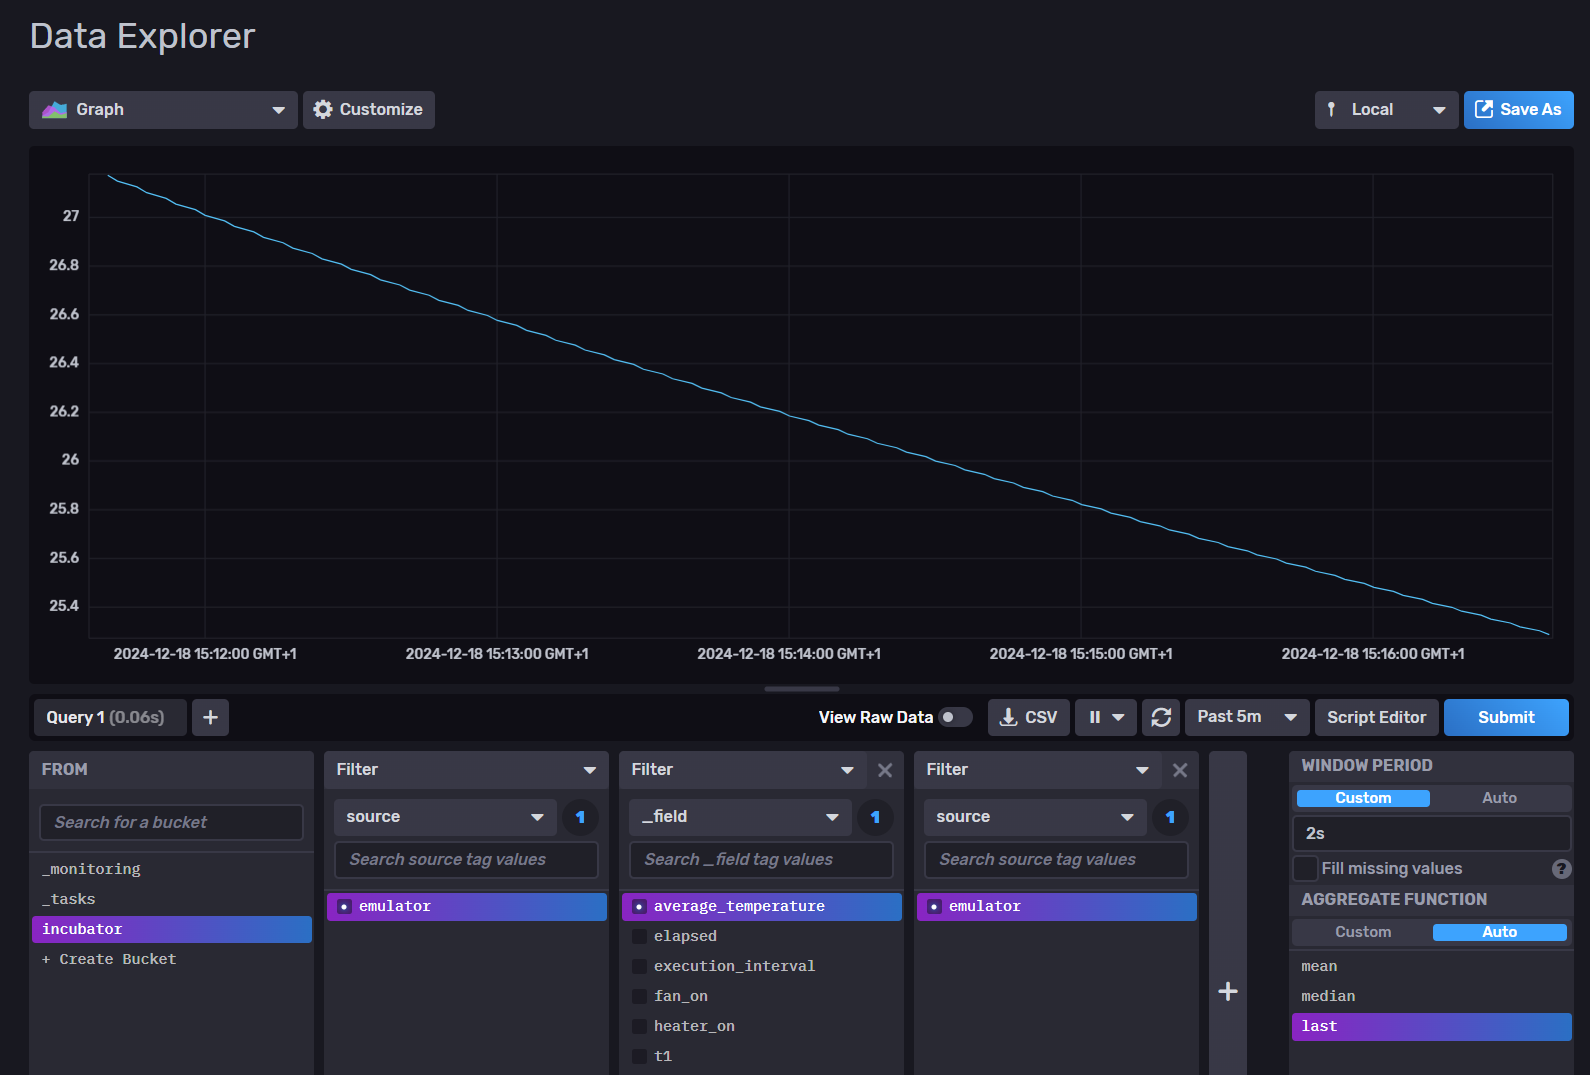

Let us now send the heater on message:

In [ ]:
# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

heater_cmd = True

# Send a message to the PT to turn on the heater
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_HEATER, {"heater": True})

# Wait a bit for the message to be processed
time.sleep(5)

And you should now see the temperature going up:

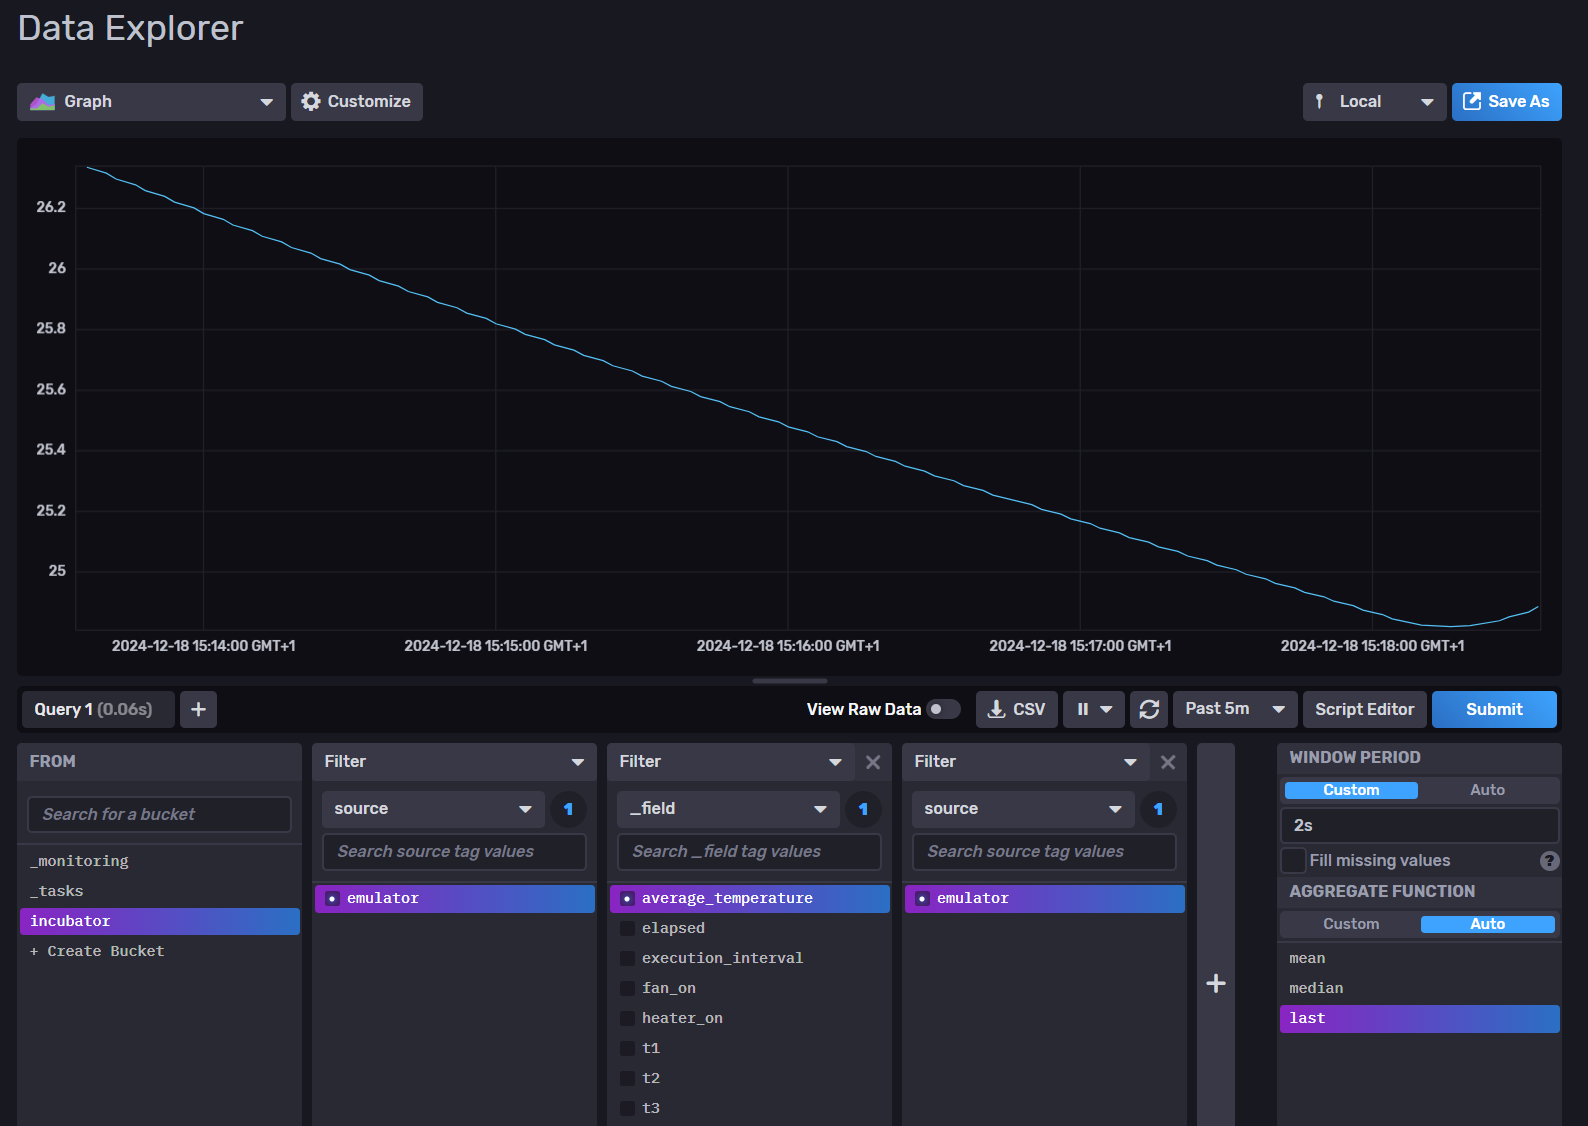

In [15]:
pt_emulator_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
pt_emulator_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert pt_emulator_service_proc.returncode is not None, 'Process has not exited'

In [16]:
incubator_data_recorder_influx_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
incubator_data_recorder_influx_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert incubator_data_recorder_influx_proc.returncode is not None, 'Process has not exited'

## Exercises

1. Adjust the incubator emulator service so that the room temperature can be changed during operation, by sending a rabbitmq message to the emulator containing the new room temperature.
2. Adjust the incubator emulator service so that one can simulate the opening of the lid, by sending a rabbitmq message to the emulator, much like the heater is turned on. To simulate the opening of the lid, all you need to do is change the `self._G_br` by, e.g., multiplying it by 10. So while the lid is open, the emulator operates with a value for `self._G_br` that's 10 times larger than the original value. To close the lid, revert `self._G_br` to its original value.
3. Adjust the incubator emulator service so that the data it produces is "noisier". For instance, use a random number generator to add noise to the temperatures measured. Adjust the random number generator according to the noise you observe in the dataset (hint: look at the room temperature as it's a relatively stable signal, so it's easier to see the noise).